# AI for Film Analysis

## Manuel Meschiari, BA (11717108)  
### GenAI Final Project

### Notebook_2: LLamaIndex

### Fourth Experiment: LLamaIndex

#### Installing Packages

In [1]:
!pip install -q openai
!pip install -q llama-index
!pip install llama-index-experimental
!pip install -q pypdf
!pip install -q docx2txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.4/327.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
import os
os.environ["OPENAI_API_KEY"] = "open_ai_key"

import sys
import shutil
import glob
import logging
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import openai

## Llamaindex readers
from llama_index.core import SimpleDirectoryReader

## LlamaIndex Index Types
from llama_index.core import ListIndex
from llama_index.core import VectorStoreIndex
from llama_index.core import TreeIndex
from llama_index.core import KeywordTableIndex
from llama_index.core import SimpleKeywordTableIndex
from llama_index.core import DocumentSummaryIndex
from llama_index.core import KnowledgeGraphIndex
from llama_index.experimental.query_engine import PandasQueryEngine


## LlamaIndex Context Managers
from llama_index.core import StorageContext
from llama_index.core import load_index_from_storage
from llama_index.core.response_synthesizers import get_response_synthesizer
from llama_index.core.response_synthesizers import ResponseMode
from llama_index.core.schema import Node

## LlamaIndex Templates
from llama_index.core.prompts import PromptTemplate
from llama_index.core.prompts import ChatPromptTemplate

## LlamaIndex Callbacks
from llama_index.core.callbacks import CallbackManager
from llama_index.core.callbacks import LlamaDebugHandler

In [4]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

In [5]:
DOCS_DIR = "./data/"
PERSIST_DIR = "./index/"

print(f"Current dir: {os.getcwd()}")

if not os.path.exists(DOCS_DIR):
  os.mkdir(DOCS_DIR)
docs = os.listdir(DOCS_DIR)
docs = [d for d in docs]
docs.sort()
print(f"Files in {DOCS_DIR}")
for doc in docs:
    print(doc)


Current dir: /content
Files in ./data/



### Creating a Vector Index    


In [6]:
if not os.path.exists(PERSIST_DIR):
    print(f"Creating Directory {PERSIST_DIR}")
    os.mkdir(PERSIST_DIR)
else:
    print(f"Re-Creating Directory {PERSIST_DIR}")
    shutil.rmtree(PERSIST_DIR)
    os.mkdir(PERSIST_DIR)

Creating Directory ./index/


In [7]:
def create_retrieve_index(index_path, docs_path, index_type):
    if not os.path.exists(index_path):
        print(f"Creating Directory {index_path}")
        os.mkdir(index_path)
    if os.listdir(index_path) == []:
        print("Loading Documents...")
        documents = SimpleDirectoryReader(docs_path).load_data()
        print("Creating Index...")
        index = index_type.from_documents(documents,
                                          show_progress=True,
                                          )
        print("Persisting Index...")
        index.storage_context.persist(persist_dir=index_path)
        print("Done!")
    else:
        print("Reading from Index...")
        index = load_index_from_storage(storage_context=StorageContext.from_defaults(persist_dir=index_path))
        print("Done!")
    return index

#### Creating Vector Store Index  

In [8]:
VECTORINDEXDIR = PERSIST_DIR + 'VectorStoreIndex'
vectorstoreindex = create_retrieve_index(VECTORINDEXDIR, DOCS_DIR, VectorStoreIndex)

Creating Directory ./index/VectorStoreIndex
Loading Documents...
Creating Index...


Parsing nodes:   0%|          | 0/275 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/284 [00:00<?, ?it/s]

Persisting Index...
Done!


### Creating a Film Studies Chatbot

In [10]:
template = (
    "Following Informations : \n"
    "---------------------\n"
    "{context_str}"
    "\n---------------------\n"
    "Only answer the question if the context provide a clear answer"
    "If the answer is not found in the document, answer: Not found in Document {query_str}\n")
qa_template = PromptTemplate(template)
chat_engine = vectorstoreindex.as_chat_engine(chat_mode="context",
                                              verbose=True,
                                              text_qa_template=qa_template)
chat_engine.reset()
chat_engine.chat_repl()

===== Entering Chat REPL =====
Type "exit" to exit.

Human: What is a "Mise-en-Scene"?
Assistant: "Mise-en-scène" is a French term that translates to "putting into the scene" in English. In the context of film and television analysis, mise-en-scène refers to everything that appears before the camera and its arrangement within the frame. This includes elements such as setting, lighting, costume, makeup, props, actors' performances, and their positioning within the frame.

Mise-en-scène plays a crucial role in conveying meaning, mood, and atmosphere in a visual medium like film or television. Filmmakers use mise-en-scène to create a specific visual aesthetic, establish the tone of a scene, and communicate themes or emotions to the audience. By carefully selecting and arranging these elements within the frame, directors can enhance the storytelling and evoke certain responses from viewers.

Overall, mise-en-scène encompasses all the visual elements that contribute to the overall look and 

In [30]:
import os
import openai
import base64
import requests
from IPython.display import Image, Audio
from openai import OpenAI

os.environ["OPENAI_API_KEY"] = "sk-proj-REYVcjcVY8GHsOgw8LoJT3BlbkFJjyyqArPHREpBeMqLUxK7"
openai.api_key = os.environ["OPENAI_API_KEY"]
model="gpt-4o"

client = OpenAI()

In [31]:
def process_image(image_path, prompt):
    with open(image_path, "rb") as image_file:
        myimage = base64.b64encode(image_file.read()).decode("utf-8")
    messages=[{"role": "system", "content": [{"type": "text", "text": f"{prompt}"}]},
              {"role": "user", "content": [{"type": "image_url", "image_url": {"url": f"data:image/png;base64,{myimage}"}}]},]
    response = client.chat.completions.create(model=model,
                                              messages=messages,
                                              temperature=1,
                                              max_tokens=2000,
                                              top_p=1,
                                              frequency_penalty=0,
                                              presence_penalty=0,
                                             )
    return response.choices[0].message.content

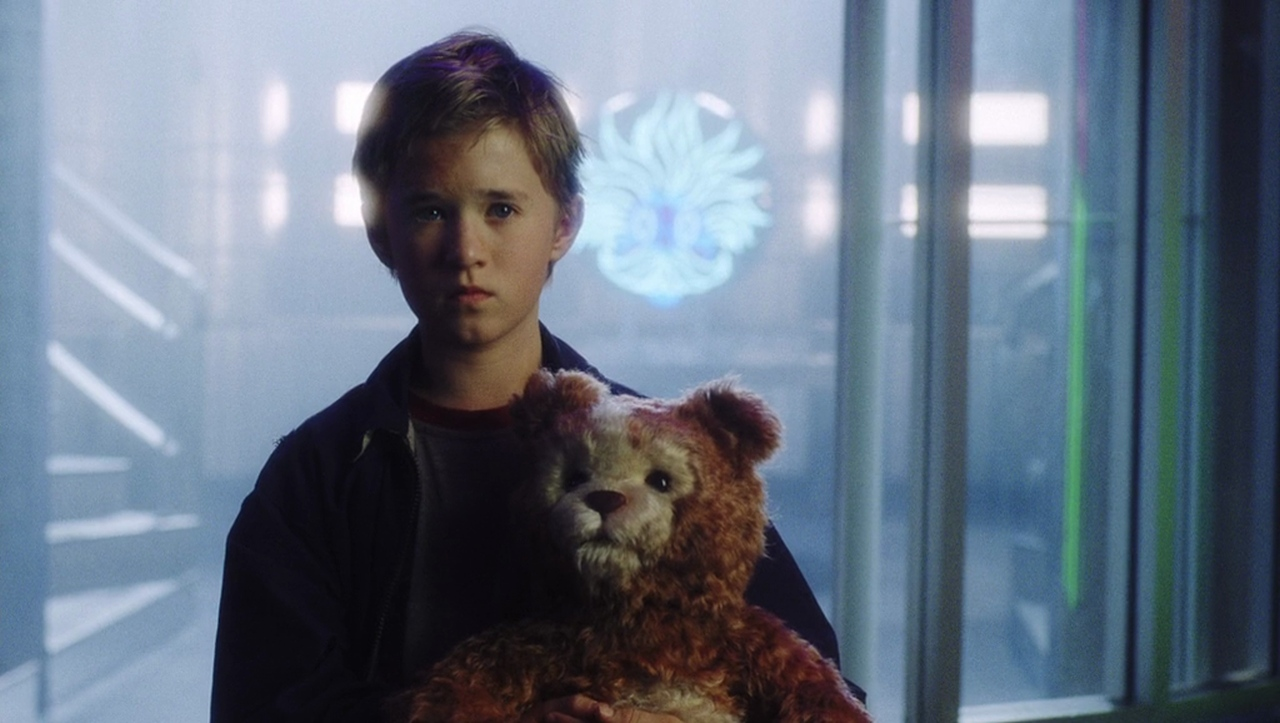

In [32]:
filename = "/content/data/a-i-artificial-intelligence-2001-1900.jpg"
Image(filename=filename, width=500)

In [40]:
query_engine = vectorstoreindex.as_query_engine(retriever_mode="embedding", response_mode= "refine", verbose=True)


response = query_engine.query("You are an expert professor in the academic discipline of Film Studies. Describe the Mise-en-Scene of this film still")
print(process_image(filename, response))

This still appears to be from the film "A.I. Artificial Intelligence," directed by Steven Spielberg.

### Mise-en-Scene Analysis:

1. **Character Positioning and Expression:**
   - The child in the center of the frame is holding a robotic teddy bear, which suggests intimacy and reliance on this toy for comfort. His expression is solemn, indicating a sense of melancholy or contemplation.
   
2. **Lighting:**
   - The lighting is soft and diffused, contributing to a contemplative and almost dreamlike atmosphere. The light source from the background casts a gentle glow, highlighting the child's face and features subtly.
   
3. **Props:**
   - The robotic teddy bear is a significant prop, symbolizing the intersection of innocence and technology. It's more than a mere toy; it represents a companion in a possibly bleak and artificial world.
   
4. **Set Design:**
   - The background, with its glass and metal elements, embodies a futuristic or clinical environment, suggesting an advanced tech